In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import models, datasets
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader

import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, recall_score, precision_score, f1_score

C:\Users\Owner\anaconda3\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\Owner\anaconda3\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: h

In [3]:
def train_fn(model, train_loader, optimizer, criterion, device="cuda"):
    model.train()
    training_run_loss = 0.0
    train_running_correct = 0

    m = len(train_loader.dataset)
    for i, data in tqdm(enumerate(train_loader), total=int(m/train_loader.batch_size)):
        image, label = data
        image = image.to(device)
        label = label.to(device)

        output = model(image)
        loss = criterion(output, label)

        training_run_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == label).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del image, label, output, preds
        torch.cuda.empty_cache()

    train_loss = training_run_loss / m
    train_accuracy = train_running_correct / m
    return train_loss, train_accuracy


def validation_fn(model, valid_loader, criterion, device="cuda"):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0

    m = len(valid_loader.dataset)
    with torch.no_grad():
        for i,data in tqdm(enumerate(valid_loader), total=int(m/valid_loader.batch_size)):
            image, label = data
            image = image.to(device)
            label = label.to(device)

            output = model(image)
            loss = criterion(output, label)

            val_running_loss += loss.item()
            _, preds = torch.max(output.data, 1)
            val_running_correct += (preds == label).sum().item()

            del image, label, output, preds
            torch.cuda.empty_cache()

        val_loss = val_running_loss / m
        val_accuracy = val_running_correct / m
        return val_loss, val_accuracy


def plot_confusion_matrix(y_t, y_p, cmap=plt.cm.Blues, title="Confusion Matrix",
                          disp_labels=None, normalize: str=None,
            ax=None, cbar=True):
    """ visualize confusion matrix """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    # display Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_t, y_p, cmap=cmap, ax=ax,
                                            display_labels=disp_labels, colorbar=cbar,
                                            xticks_rotation=45, normalize=normalize);

    plt.title(title)
    plt.xlabel("Prediction")
    plt.ylabel("Actual")


def plot_vals(train_vals: list, valid_vals: list, val: str="Loss"):
    epoch_count = range(1, len(train_vals) + 1)
    fig = plt.figure(figsize=(8,8))
    plt.plot(epoch_count, train_vals, 'g', label=f'training {val}')
    plt.plot(epoch_count, valid_vals, 'b', label=f'validation {val}')
    plt.title(f'Training and Validation {val}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{val}')
    plt.legend()
    return fig


In [25]:
cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [4]:
dir_train = 'C:/Users/Owner/Desktop/Single-modal- VIRI/tran_val_test/IR/train/'
dir_val = 'C:/Users/Owner/Desktop/Single-modal- VIRI/tran_val_test/IR/val/'

In [6]:
# augmentation
def augment_data(img_path: Path, transforms_list: list, save_dir: str="") -> None:
    """ augment image and save to directory """
    image = Image.open(img_path).convert("RGB")
    # label
    label = img_path.parent.name
    # name
    img_name = img_path.stem

    # save original image
    save_name = Path(save_dir, label, f"{img_name}.JPG")
    image.save(save_name)
    
    # apply transforms
    for transform, count, name in transforms_list:
        for k in range(count):
            t_img = transform(image)
            save_name_as = Path(save_name.parent, f"{img_name}_{name}_{k+1}.JPG")
            t_img.save(save_name_as)

 
# aug_transforms is a list of the augmentations to be carried out, of the format: (T.Transform, number of times to apply transform, name of transform to append to original file)
aug_transforms = [
        (T.RandomRotation(20), 5, "rotation"),
        (T.RandomZoomOut(fill=123, p=1, side_range=(1, 1.5)), 5, "zoom"),
        (T.RandomPerspective(distortion_scale=0.5, p=1), 5, "distortion"),
        (T.RandomAffine(degrees=20, shear=0.2), 5, "shear"),
        (T.RandomHorizontalFlip(p=1), 5, "hflip"),
    ]

# create a new directory to save the augmented train data
dir_train_aug = Path(f"C:/Users/Owner/Desktop/Single-modal- VIRI/IR/train_aug_images/")
if dir_train_aug.exists():
    shutil.rmtree(dir_train_aug)

# create sub-directories
for i in ["Surprise", "Angry", "Neutral", "Sad", "Happy"]:
    Path(dir_train_aug, i).mkdir(parents=True)

# augment
images = [i for i in Path(dir_train).rglob("*.JPG")]
for img_path in tqdm(images):
    augment_data(img_path, aug_transforms, save_dir=dir_train_aug)

100%|██████████| 393/393 [00:47<00:00,  8.25it/s]


In [7]:
# train distribution before augmentation
for i in Path(dir_train).iterdir():
    x = len([j for j in i.glob("*.JPG")])
    print(f"{i.name}: {x}")

Angry: 77
Happy: 79
Neutral: 79
Sad: 79
Surprise: 79


In [8]:
# train distribution after augmentation
for i in Path(dir_train_aug).iterdir():
    x = len([j for j in i.glob("*.JPG")])
    print(f"{i.name}: {x}")

Angry: 2002
Happy: 2054
Neutral: 2054
Sad: 2054
Surprise: 2054


In [9]:
# validation
for i in Path(dir_val).iterdir():
    x = len([j for j in i.glob("*.JPG")])
    print(f"{i.name}: {x}")


Angry: 16
Happy: 17
Neutral: 17
Sad: 17
Surprise: 16


In [10]:
data_transforms = T.Compose([
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
    T.Resize((224,224), antialias=True),
])

# data
train_data = datasets.ImageFolder(root=dir_train_aug, transform=data_transforms)
val_data = datasets.ImageFolder(root=dir_val, transform=data_transforms)

In [11]:
# extract labels_map
labels_map = train_data.class_to_idx
labels_map = {v:k for k,v in labels_map.items()}
labels_map

{0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'Sad', 4: 'Surprise'}

In [85]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_data, batch_size=8, shuffle=False)

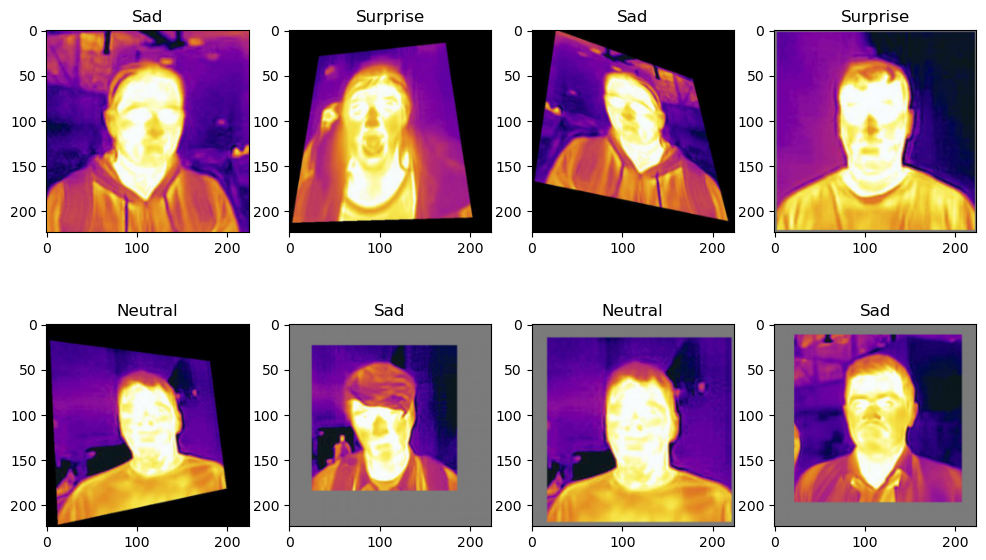

In [86]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(12, 7))
for idx in range(8):
    ax = plt.subplot(2, 4, idx+1)
    img = T.ToPILImage()(images[idx])
    label = labels_map.get(labels[idx].item())
    ax.imshow(img)
    ax.set_title(label)

## Train

In [170]:
# Define Attention module
class SimpleAttention(nn.Module):
    def __init__(self, in_features, out_features):
        super(SimpleAttention, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):

        attention_weights = torch.sigmoid(self.fc(x*x))

        x = x * attention_weights
        return x

# Define Attention module
class SimpleResNetWithAttention(nn.Module):
    def __init__(self, num_classes):
        super(SimpleResNetWithAttention, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # Define the attention mechanism
        self.attention = SimpleAttention(512, 512)
        self.fc = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(512, 256),  # First Linear layer
            nn.ReLU(),
            nn.BatchNorm1d(256),  # BatchNorm1d added here, after ReLU
            nn.Dropout(0.8),
            nn.Linear(256, 5),  # Output layer
            nn.Softmax(dim=1)   # Make sure to use dim=1 for batch-wise operations
        )   
        

    def forward(self, x, inference=False):
        x = self.resnet(x)

        # Apply attention mechanism
        x = x.view(x.size(0), -1)  # Flatten before attention
        x = self.attention(x)

        # Classification layer
        x = self.fc(x)
        return x

model = SimpleResNetWithAttention(num_classes=5)    
model_name = "resnet18withattention"
print(model)
model.to(DEVICE)

SimpleResNetWithAttention(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

SimpleResNetWithAttention(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [171]:
criterion = nn.CrossEntropyLoss()
epochs = 50

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)
Path("C:/Users/Owner/Desktop/Single-modal- VIRI/IR/models/").mkdir(exist_ok=True)

In [172]:
train_acc, train_loss = [], []
val_acc, val_loss = [], []
lrs = []
best_acc = 0.0
best_loss = torch.inf

for epoch in range(1, epochs+1):
    print(f"Epoch: {epoch}/{epochs}")

    ##save lr for epoch
    epoch_lr = optimizer.param_groups[0]["lr"]
    #lrs.append(epoch_lr)
    lr_scheduler.step()

    # train for one epoch
    train_loss_ep, train_acc_ep = train_fn(model, train_loader, optimizer, criterion, device=DEVICE)
    val_loss_ep, val_acc_ep = validation_fn(model, valid_loader, criterion, device=DEVICE)
    lr_scheduler.step(val_acc_ep)
    
    # append train metrics
    train_acc.append(train_acc_ep)
    train_loss.append(train_loss_ep)

    # append val metrics
    val_acc.append(val_acc_ep)
    val_loss.append(val_loss_ep)

    print(f'loss {train_loss_ep:.3f} -acc {train_acc_ep:.3f} - val_loss {val_loss_ep:.3f} -val_acc {val_acc_ep:.3f}')
    if val_acc_ep >= best_acc:
        best_acc = val_acc_ep
        torch.save(model.state_dict(), f'C:/Users/Owner/Desktop/Single-modal- VIRI/IR/models/{model_name}_{epoch}_{best_acc:.3f}_weights.pt')
        print("=> saved best model")
        torch.cuda.empty_cache()
    
    if epoch == epochs:
      # save model weights at last epoch
      torch.save(model.state_dict(), f'C:/Users/Owner/Desktop/Single-modal- VIRI/IR/models/{model_name}_last_weights.pt')

Epoch: 1/50


160it [00:26,  6.07it/s]                         
11it [00:00, 30.10it/s]                        


loss 0.024 -acc 0.301 - val_loss 0.208 -val_acc 0.241
=> saved best model
Epoch: 2/50


160it [00:26,  6.11it/s]                         
11it [00:00, 31.60it/s]                       


loss 0.021 -acc 0.578 - val_loss 0.216 -val_acc 0.265
=> saved best model
Epoch: 3/50


160it [00:25,  6.18it/s]                         
11it [00:00, 30.54it/s]                       


loss 0.018 -acc 0.729 - val_loss 0.201 -val_acc 0.386
=> saved best model
Epoch: 4/50


160it [00:26,  6.14it/s]                         
11it [00:00, 31.43it/s]                       


loss 0.017 -acc 0.815 - val_loss 0.202 -val_acc 0.373
Epoch: 5/50


160it [00:25,  6.16it/s]                         
11it [00:00, 30.63it/s]                       


loss 0.016 -acc 0.862 - val_loss 0.198 -val_acc 0.398
=> saved best model
Epoch: 6/50


160it [00:26,  6.12it/s]                         
11it [00:00, 30.52it/s]                        


loss 0.016 -acc 0.894 - val_loss 0.190 -val_acc 0.446
=> saved best model
Epoch: 7/50


160it [00:26,  6.14it/s]                         
11it [00:00, 31.36it/s]                       


loss 0.015 -acc 0.930 - val_loss 0.205 -val_acc 0.373
Epoch: 8/50


160it [00:25,  6.18it/s]                         
11it [00:00, 31.76it/s]                       


loss 0.015 -acc 0.929 - val_loss 0.196 -val_acc 0.410
Epoch: 9/50


160it [00:25,  6.16it/s]                         
11it [00:00, 31.45it/s]                       


loss 0.015 -acc 0.931 - val_loss 0.200 -val_acc 0.373
Epoch: 10/50


160it [00:26,  6.12it/s]                         
11it [00:00, 33.03it/s]                       


loss 0.015 -acc 0.943 - val_loss 0.201 -val_acc 0.361
Epoch: 11/50


160it [00:25,  6.16it/s]                         
11it [00:00, 31.66it/s]                       


loss 0.015 -acc 0.949 - val_loss 0.204 -val_acc 0.361
Epoch: 12/50


160it [00:26,  6.14it/s]                         
11it [00:00, 31.09it/s]                        


loss 0.015 -acc 0.935 - val_loss 0.206 -val_acc 0.349
Epoch: 13/50


160it [00:25,  6.18it/s]                         
11it [00:00, 30.20it/s]                        


loss 0.015 -acc 0.947 - val_loss 0.199 -val_acc 0.422
Epoch: 14/50


160it [00:25,  6.17it/s]                         
11it [00:00, 32.23it/s]                       


loss 0.015 -acc 0.968 - val_loss 0.196 -val_acc 0.398
Epoch: 15/50


160it [00:25,  6.20it/s]                         
11it [00:00, 31.93it/s]                       


loss 0.015 -acc 0.962 - val_loss 0.196 -val_acc 0.434
Epoch: 16/50


160it [00:26,  6.10it/s]                         
11it [00:00, 33.25it/s]                       


loss 0.015 -acc 0.961 - val_loss 0.199 -val_acc 0.386
Epoch: 17/50


160it [00:26,  6.14it/s]                         
11it [00:00, 31.44it/s]                       


loss 0.015 -acc 0.956 - val_loss 0.196 -val_acc 0.398
Epoch: 18/50


160it [00:26,  6.07it/s]                         
11it [00:00, 30.87it/s]                       


loss 0.015 -acc 0.950 - val_loss 0.189 -val_acc 0.458
=> saved best model
Epoch: 19/50


160it [00:26,  6.15it/s]                         
11it [00:00, 31.04it/s]                       


loss 0.015 -acc 0.966 - val_loss 0.185 -val_acc 0.494
=> saved best model
Epoch: 20/50


160it [00:26,  6.15it/s]                         
11it [00:00, 31.51it/s]                       


loss 0.015 -acc 0.977 - val_loss 0.193 -val_acc 0.422
Epoch: 21/50


160it [00:25,  6.17it/s]                         
11it [00:00, 31.40it/s]                       


loss 0.015 -acc 0.972 - val_loss 0.199 -val_acc 0.410
Epoch: 22/50


160it [00:25,  6.18it/s]                         
11it [00:00, 30.61it/s]                       


loss 0.015 -acc 0.963 - val_loss 0.191 -val_acc 0.458
Epoch: 23/50


160it [00:26,  6.09it/s]                         
11it [00:00, 30.68it/s]                       


loss 0.015 -acc 0.976 - val_loss 0.190 -val_acc 0.458
Epoch: 24/50


160it [00:25,  6.19it/s]                         
11it [00:00, 33.22it/s]                       


loss 0.015 -acc 0.966 - val_loss 0.194 -val_acc 0.434
Epoch: 25/50


160it [00:26,  6.13it/s]                         
11it [00:00, 30.44it/s]                        


loss 0.015 -acc 0.962 - val_loss 0.190 -val_acc 0.482
Epoch: 26/50


160it [00:26,  6.14it/s]                         
11it [00:00, 31.57it/s]                       


loss 0.015 -acc 0.978 - val_loss 0.197 -val_acc 0.410
Epoch: 27/50


160it [00:27,  5.87it/s]                         
11it [00:00, 33.35it/s]                       


loss 0.015 -acc 0.974 - val_loss 0.196 -val_acc 0.422
Epoch: 28/50


160it [00:26,  6.05it/s]                         
11it [00:00, 31.18it/s]                       


loss 0.014 -acc 0.982 - val_loss 0.194 -val_acc 0.422
Epoch: 29/50


160it [00:27,  5.89it/s]                         
11it [00:00, 29.73it/s]                       


loss 0.015 -acc 0.972 - val_loss 0.191 -val_acc 0.446
Epoch: 30/50


160it [00:26,  5.95it/s]                         
11it [00:00, 29.88it/s]                       


loss 0.015 -acc 0.968 - val_loss 0.193 -val_acc 0.458
Epoch: 31/50


160it [00:27,  5.92it/s]                         
11it [00:00, 31.50it/s]                       


loss 0.015 -acc 0.976 - val_loss 0.192 -val_acc 0.470
Epoch: 32/50


160it [00:26,  6.12it/s]                         
11it [00:00, 31.28it/s]                       


loss 0.015 -acc 0.979 - val_loss 0.197 -val_acc 0.410
Epoch: 33/50


160it [00:26,  6.15it/s]                         
11it [00:00, 33.33it/s]                       


loss 0.014 -acc 0.986 - val_loss 0.197 -val_acc 0.410
Epoch: 34/50


160it [00:25,  6.15it/s]                         
11it [00:00, 32.02it/s]                       


loss 0.015 -acc 0.976 - val_loss 0.193 -val_acc 0.434
Epoch: 35/50


160it [00:27,  5.88it/s]                         
11it [00:00, 29.50it/s]                       


loss 0.015 -acc 0.970 - val_loss 0.201 -val_acc 0.373
Epoch: 36/50


160it [00:26,  6.13it/s]                         
11it [00:00, 33.07it/s]                       


loss 0.015 -acc 0.953 - val_loss 0.191 -val_acc 0.458
Epoch: 37/50


160it [00:25,  6.16it/s]                         
11it [00:00, 32.12it/s]                       


loss 0.015 -acc 0.974 - val_loss 0.195 -val_acc 0.434
Epoch: 38/50


160it [00:25,  6.20it/s]                         
11it [00:00, 31.51it/s]                        


loss 0.015 -acc 0.974 - val_loss 0.204 -val_acc 0.349
Epoch: 39/50


160it [00:26,  6.13it/s]                         
11it [00:00, 32.20it/s]                       


loss 0.014 -acc 0.980 - val_loss 0.194 -val_acc 0.422
Epoch: 40/50


160it [00:26,  6.12it/s]                         
11it [00:00, 28.58it/s]                        


loss 0.014 -acc 0.979 - val_loss 0.195 -val_acc 0.434
Epoch: 41/50


160it [00:26,  6.09it/s]                         
11it [00:00, 31.44it/s]                       


loss 0.015 -acc 0.977 - val_loss 0.189 -val_acc 0.482
Epoch: 42/50


160it [00:26,  6.01it/s]                         
11it [00:00, 31.55it/s]                       


loss 0.014 -acc 0.981 - val_loss 0.195 -val_acc 0.434
Epoch: 43/50


160it [00:26,  5.96it/s]                         
11it [00:00, 31.54it/s]                       


loss 0.014 -acc 0.986 - val_loss 0.192 -val_acc 0.458
Epoch: 44/50


160it [00:26,  5.97it/s]                         
11it [00:00, 30.72it/s]                        


loss 0.014 -acc 0.981 - val_loss 0.192 -val_acc 0.458
Epoch: 45/50


160it [00:26,  5.99it/s]                         
11it [00:00, 33.77it/s]                       


loss 0.014 -acc 0.984 - val_loss 0.188 -val_acc 0.458
Epoch: 46/50


160it [00:25,  6.16it/s]                         
11it [00:00, 31.20it/s]                        


loss 0.014 -acc 0.980 - val_loss 0.194 -val_acc 0.446
Epoch: 47/50


160it [00:26,  6.15it/s]                         
11it [00:00, 31.42it/s]                       


loss 0.014 -acc 0.980 - val_loss 0.197 -val_acc 0.422
Epoch: 48/50


160it [00:26,  6.10it/s]                         
11it [00:00, 31.83it/s]                       


loss 0.015 -acc 0.978 - val_loss 0.193 -val_acc 0.434
Epoch: 49/50


160it [00:26,  5.98it/s]                         
11it [00:00, 32.48it/s]                        


loss 0.015 -acc 0.972 - val_loss 0.188 -val_acc 0.470
Epoch: 50/50


160it [00:27,  5.88it/s]                         
11it [00:00, 32.37it/s]                        

loss 0.014 -acc 0.986 - val_loss 0.190 -val_acc 0.458


In [207]:
model.load_state_dict(torch.load(r"C:\Users\Owner\Desktop\Single-modal- VIRI\IR\models\resnet18withattention_18_0.458_weights.pt", map_location=torch.device(DEVICE)))

<All keys matched successfully>

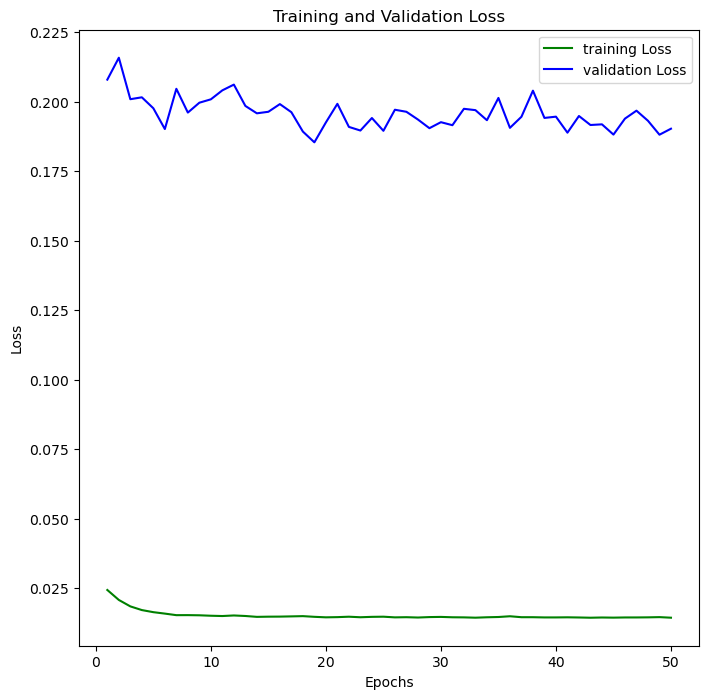

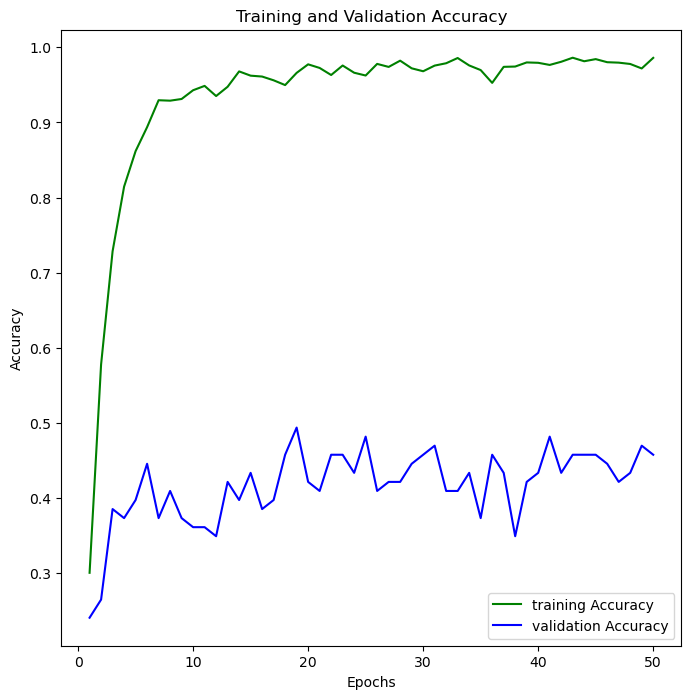

In [208]:
_ = plot_vals(train_loss, val_loss)
plt.savefig(f"C:/Users/Owner/Desktop/Single-modal- VIRI/Vis/models/{model_name}_losses.jpg")

_ = plot_vals(train_acc, val_acc, val="Accuracy")
plt.savefig(f"C:/Users/Owner/Desktop/Single-modal- VIRI/Vis/models/{model_name}_accuracy.jpg")

## Evaluation

In [209]:
# val
val_preds = []
val_labels = []
model.eval()
for idx, (images, labels) in enumerate(valid_loader):
    outputs = model(images.to(DEVICE))
    soft_outs = F.softmax(outputs, dim=1)
    probs, preds = torch.max(soft_outs.data, 1)
    val_preds.extend(preds.tolist())
    val_labels.extend(labels.tolist())

yt = np.array(val_labels)
yp = np.array(val_preds)

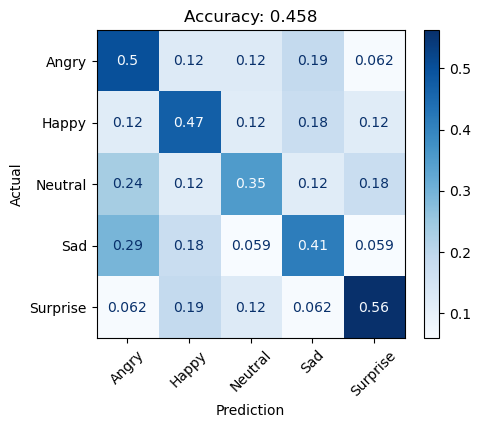

In [210]:
mask = yt == yp
acc = mask.sum() / len(yt)

disp_labels = list(labels_map.values())
title = f"Accuracy: {acc:.3f}"
plot_confusion_matrix(yt, yp, title=title,
                      disp_labels=disp_labels, normalize='true')

In [211]:
dir_test = "C:/Users/Owner/Desktop/Single-modal- VIRI/tran_val_test/IR/test/"
test_data = datasets.ImageFolder(root=dir_test, transform=data_transforms)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [212]:
# test
test_preds = []
test_labels = []
model.eval()
for idx, (images, labels) in enumerate(test_loader):
    outputs = model(images.to(DEVICE))
    soft_outs = F.softmax(outputs, dim=1)
    probs, preds = torch.max(soft_outs.data, 1)
    test_preds.extend(preds.tolist())
    test_labels.extend(labels.tolist())

yt = np.array(test_labels)
yp = np.array(test_preds)

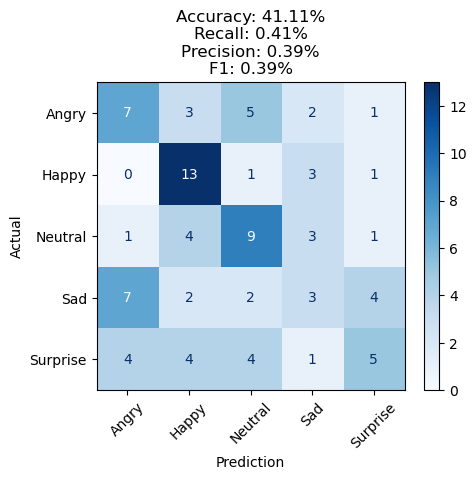

In [213]:
acc = accuracy_score(yt, yp)
recall = recall_score(yt, yp, average="weighted")
precision = precision_score(yt, yp, average="weighted")
f1 = f1_score(yt, yp, average="weighted")

disp_labels = list(labels_map.values())
title = f"Accuracy: {acc*100:.2f}%\nRecall: {recall:.2f}%\nPrecision: {precision:.2f}%\nF1: {f1:.2f}%"

plot_confusion_matrix(yt, yp, title=title,
                      disp_labels=disp_labels)  #, normalize='true')
plt.savefig(f"C:/Users/Owner/Desktop/Single-modal- VIRI/IR/results/{model_name}_test_conf_norm.png", bbox_inches="tight")